# Reddit Project - Sports vs Esports

---

## Table of Contents


- [Get and read in Data](#data)

- [Preprocessing](#pre)

- [EDA](#eda)

- [Modeling](#models)

- [Classification Metrics](#class_metrics)

- [Top Words](#top_words)

---

### Imports

In [24]:
import requests
import pandas as pd
import numpy as np

import nltk
import regex as re
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer 
from nltk.stem.porter import PorterStemmer

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB, GaussianNB

import matplotlib.pyplot as plt

---

## Get and read in Data <a id='read'></a>

In [25]:
url = 'https://api.pushshift.io/reddit/search/submission'

params_es = {
    'subreddit': 'esports',
    'size': 1000
}

params_s = {
    'subreddit': 'sports',
    'size': 1000
}

In [26]:
import time
time.sleep(3)
res_es = requests.get(url, params_es)
res_s = requests.get(url, params_s)

print('r/esports status code:', res_es.status_code)
print('r/sports status code:', res_s.status_code)

r/esports status code: 200
r/sports status code: 200


In [27]:
data_es = res_es.json()
data_s = res_s.json()

esports = data_es['data']
sports = data_s['data']

print(f'r/esports posts: {len(esports)}')
print(f'r/sports posts: {len(sports)}')

r/esports posts: 1000
r/sports posts: 1000


In [28]:
esp = pd.DataFrame(esports)
sp = pd.DataFrame(sports)

# create dataframes only for relevant features
esp = esp[['subreddit', 'selftext', 'title']].copy()

sp = sp[['subreddit', 'selftext', 'title']].copy()

---

## Preprocessing <a id='pre'></a>

- Tokenizing
- Regular Expressions
- Lemmatizing/Stemming
- Cleaning

### Cleaning

In [29]:
# option to view full title text
pd.options.display.max_rows
pd.set_option('display.max_colwidth', -1)
# https://songhuiming.github.io/pages/2017/04/02/jupyter-and-pandas-display/

# combine data frames
df = esp.append(sp, ignore_index=True)
df.subreddit.value_counts()

/Users/aidandominguez/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  This is separate from the ipykernel package so we can avoid doing imports until


sports     1000
esports    1000
Name: subreddit, dtype: int64

In [30]:
# change NaN entry for selftext to empty string
df[df.selftext.isnull()]['title']

df.selftext.fillna('', inplace=True)

In [31]:
df.isnull().sum()

subreddit    0
selftext     0
title        0
dtype: int64

### Regular Expressions

In [32]:
# remove any urls, etc.
df.title = df.title.replace('http\S+', '', regex=True).replace('www\S+', '', regex=True).replace('#\S+', '', regex=True).replace('\n\n\S+', '', regex=True)

# remove all non-english characters and numbers
df.title = df.title.map(lambda x: re.sub('[^a-zA-z ]','', x))
df.selftext = df.selftext.map(lambda x: re.sub('[^a-zA-z ]','', x))

df.title.head()

0    Charity esports stream to raise money for Project HOPE                    
1    Any Teams Looking For an editor                                           
2    Dual Diagnosis Treatment Centers Massachusetts                            
3    Not everything is perfect what are some of the biggest issues with esports
4    Huh                                                                       
Name: title, dtype: object

### Tokenizing & Lemmatizing

In [33]:
# tokenize title entries
tokenizer = RegexpTokenizer(r'\w+')
df['title_tokens'] = df['title'].map(lambda entry: tokenizer.tokenize(entry))

In [34]:
# lemmatize title tokens
lemmatizer = WordNetLemmatizer()
df['title_lemmatized'] = df['title_tokens'].map(lambda list_of_words: [
    lemmatizer.lemmatize(word.lower()) for word in list_of_words ])

In [35]:
df['title_adjusted'] = df['title_lemmatized'].str.join(' ')
df.head()

,subreddit,selftext,title,title_tokens,title_lemmatized,title_adjusted
0,esports,,Charity esports stream to raise money for Project HOPE,"[Charity, esports, stream, to, raise, money, for, Project, HOPE]","[charity, esports, stream, to, raise, money, for, project, hope]",charity esports stream to raise money for project hope
1,esports,Any Teams Looking For an editorAll My Work is mjsouls\_ on instagramIm Looking to improve as well,Any Teams Looking For an editor,"[Any, Teams, Looking, For, an, editor]","[any, team, looking, for, an, editor]",any team looking for an editor
2,esports,,Dual Diagnosis Treatment Centers Massachusetts,"[Dual, Diagnosis, Treatment, Centers, Massachusetts]","[dual, diagnosis, treatment, center, massachusetts]",dual diagnosis treatment center massachusetts
3,esports,Exactly what the title says why hasnt it broken out to mainstream media Why does it feel stagnant Etc Just looking for some insight not meant to belittle of offend,Not everything is perfect what are some of the biggest issues with esports,"[Not, everything, is, perfect, what, are, some, of, the, biggest, issues, with, esports]","[not, everything, is, perfect, what, are, some, of, the, biggest, issue, with, esports]",not everything is perfect what are some of the biggest issue with esports
4,esports,Can I post team recruitment here,Huh,[Huh],[huh],huh


---

## EDA <a id='eda'></a>
>- Found character and word counts and on average the r/Esports posts had more words and characters than r/Sports posts
- Cleaned dataset by removing entries where there were no titles (`13`)
- Used Count Vectorizer to assess key words form each subreddit 
    - top 20 similar words between the two subreddits : `['league', 'team', 'game', 'coronavirus', 'player', 'new', 'sport', 'covid']`

In [36]:
# find character count
df['char_count'] = df['title'].map(len)
# find word count
df['word_count'] = df['title'].map(lambda x: len(x.split()))

df.head()

,subreddit,selftext,title,title_tokens,title_lemmatized,title_adjusted,char_count,word_count
0,esports,,Charity esports stream to raise money for Project HOPE,"[Charity, esports, stream, to, raise, money, for, Project, HOPE]","[charity, esports, stream, to, raise, money, for, project, hope]",charity esports stream to raise money for project hope,54,9
1,esports,Any Teams Looking For an editorAll My Work is mjsouls\_ on instagramIm Looking to improve as well,Any Teams Looking For an editor,"[Any, Teams, Looking, For, an, editor]","[any, team, looking, for, an, editor]",any team looking for an editor,31,6
2,esports,,Dual Diagnosis Treatment Centers Massachusetts,"[Dual, Diagnosis, Treatment, Centers, Massachusetts]","[dual, diagnosis, treatment, center, massachusetts]",dual diagnosis treatment center massachusetts,46,5
3,esports,Exactly what the title says why hasnt it broken out to mainstream media Why does it feel stagnant Etc Just looking for some insight not meant to belittle of offend,Not everything is perfect what are some of the biggest issues with esports,"[Not, everything, is, perfect, what, are, some, of, the, biggest, issues, with, esports]","[not, everything, is, perfect, what, are, some, of, the, biggest, issue, with, esports]",not everything is perfect what are some of the biggest issue with esports,74,13
4,esports,Can I post team recruitment here,Huh,[Huh],[huh],huh,3,1


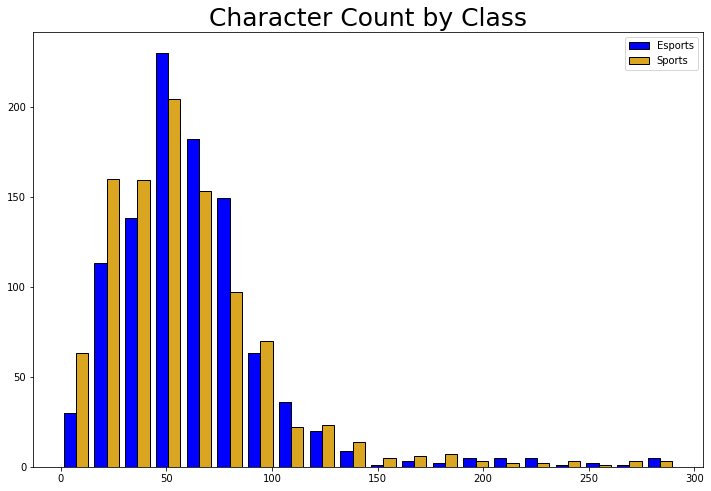

In [37]:
# Character count by class
plt.figure(figsize=(12, 8))
plt.hist([df[df.subreddit == 'esports']['char_count'],
        df[df.subreddit == 'sports']['char_count']],
        bins=20, color=['blue', 'goldenrod'], ec='k')
plt.title('Character Count by Class', fontsize=25)
plt.legend(['Esports', 'Sports']);

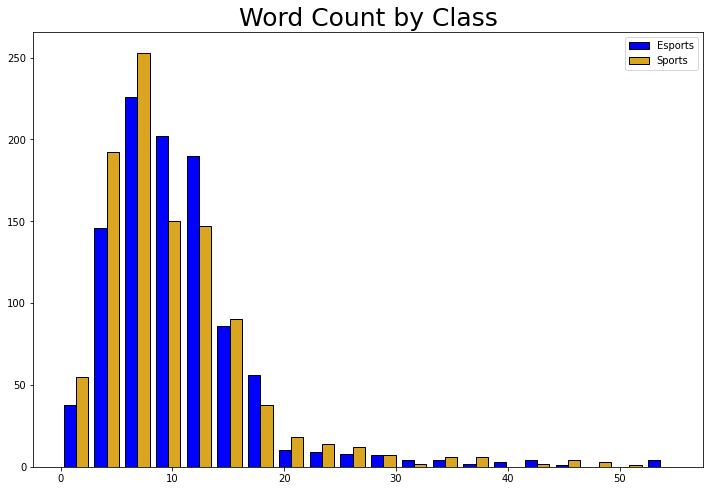

In [38]:
# Word count by class
plt.figure(figsize=(12, 8))
plt.hist([df[df.subreddit == 'esports']['word_count'],
        df[df.subreddit == 'sports']['word_count']],
        bins=20, color=['blue', 'goldenrod'], ec='k')
plt.title('Word Count by Class', fontsize=25)
plt.legend(['Esports', 'Sports']);

**Cleaning nulls**

In [39]:
df[df['title']==''][:] # only one post has selftext with empty title - drop all

,subreddit,selftext,title,title_tokens,title_lemmatized,title_adjusted,char_count,word_count
275,esports,Hello im a new streamer that tries to get more followers i play csgo valorant css some other games too i would apprusiate if u can take seconds and go follow mw an turn on notifications [httpswwwtwitchtvsnowtv]httpswwwtwitchtvsnowtv Best regards mr snow,,[],[],,0,0
343,esports,,,[],[],,0,0
370,esports,,,[],[],,0,0
716,esports,,,[],[],,0,0
729,esports,,,[],[],,0,0
730,esports,,,[],[],,0,0
732,esports,,,[],[],,0,0
782,esports,,,[],[],,0,0
877,esports,,,[],[],,0,0
911,esports,German soccer professionals from Hanover are playing FIFA tournament online The starting fees per player are donated[httpswwwhannoverdeesportslivestreamstayathomecuphtml]httpswwwhannoverdeesportslivestreamstayathomecuphtml,,[],[],,0,0


In [40]:
df = df.drop(index=df[df['title']==''].index)

In [41]:
df['subreddit'] = df['subreddit'].map({'sports':0, 'esports': 1})

df['subreddit'].head()

0    1
1    1
2    1
3    1
4    1
Name: subreddit, dtype: int64

### Count Vectorizer

In [42]:
X = df['title_adjusted']

cvec = CountVectorizer(stop_words='english',
                      lowercase=True,
                      min_df = 3)

X_text = cvec.fit_transform(X)

term_df = pd.DataFrame(X_text.toarray(), columns=cvec.get_feature_names())
#term_df.insert(0, 'target', df['subreddit'])

In [67]:
print('Sports top words')
term_df.groupby('target').mean().T.sort_values(1, ascending=False).head(10).index.to_frame()

Sports top words


,0
coutinho,coutinho
chelsea,chelsea
miss,miss
league,league
transfer,transfer
newcastle,newcastle
title,title
race,race
join,join
mourinho,mourinho


In [65]:
print('Esports top words')
term_df.groupby('target').mean().T.sort_values(0, ascending=False).head(10).index.to_frame()

Esports top words


,0
esports,esports
league,league
game,game
team,team
valorant,valorant
sport,sport
player,player
tournament,tournament
new,new
csgo,csgo


In [45]:
top_sports_words = list(term_df.groupby('target').mean().T.sort_values(0, ascending=False).head(20).index)
top_esports_words = list(term_df.groupby('target').mean().T.sort_values(1, ascending=False).head(20).index)
[word for word in top_esports_words if word in top_sports_words]

['league']

---

## Modeling <a id='models'></a>
>- Used `GridSearchCV` when testing better-performing models
- Models fit and tested: `Logistic Regression`, `KNN`, `MultinomialNB`, `GaussianNB`, and `SVM Polynomial Kernel`
- Two best models were **`MultinomialNB`** and **`Logistic Regression`**
    - Final model: **`MultinomialNB`**
        - After grid searching, MultinomialNB had a slighlty higher test score, so it was chosen as the best model despite both models being slightly underfit
       

In [46]:
X = df['title_adjusted']
y = df['subreddit']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=13)

### KNN

In [47]:
from sklearn.neighbors import KNeighborsClassifier

pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('knn', KNeighborsClassifier())
])

gs = GridSearchCV(pipe,
                  {'cvec__min_df': [1, 3, 5, 7],
                   'cvec__max_features': [100, 500, 1000],
                   'cvec__stop_words': ['english'],
                   'knn__n_neighbors': [5, 10, 20, 50, 100]},
                 cv = 5,
                 verbose = 1,
                 n_jobs = -1)

results_knn = gs.fit(X_train, y_train)

print('best params:', results_knn.best_params_, '\n')

print('training score:', results_knn.best_score_)
print('testing score:', results_knn.score(X_test, y_test))

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   12.6s


best params: {'cvec__max_features': 100, 'cvec__min_df': 5, 'cvec__stop_words': 'english', 'knn__n_neighbors': 5} 

training score: 0.8077956989247311
testing score: 0.6680080482897385


[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   16.7s finished


### SVM Polynomial Kernel

In [48]:
X_train_cvec = cvec.fit_transform(X_train)
X_test_cvec = cvec.transform(X_test)

svc = SVC(random_state=13, gamma='scale', kernel='poly')
svc.fit(X_train_cvec, y_train)

print('SVM Poly training score:', svc.score(X_train_cvec, y_train))
print('SVM Poly testing score:', svc.score(X_test_cvec, y_test))

SVM Poly training score: 0.885752688172043
SVM Poly testing score: 0.7404426559356136


In [49]:
# Pipeline and GridSearchCV for MultinomialNB
pipe_complex = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('model', SVC(gamma='scale', kernel='poly'))
])
    
hyperparams = {
    'vectorizer__max_features': [100, 500, None],
    'vectorizer__stop_words': ['english', None],
    'vectorizer__ngram_range': [(1,1), (1,2), (2,2)],
}
    
gs_complex = GridSearchCV(pipe_complex,
                          hyperparams,
                          verbose = 1,
                          cv = 5,
                          n_jobs = -1,
                          scoring = 'accuracy')

results_svm = gs_complex.fit(X_train, y_train)

print(results_svm.best_params_, '\n')
print(print('SVM grid training score:', results_svm.best_score_))
print('SVM grid testing score:', results_svm.score(X_test, y_test))

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    7.6s


{'vectorizer__max_features': 100, 'vectorizer__ngram_range': (1, 1), 'vectorizer__stop_words': 'english'} 

SVM grid training score: 0.8084677419354839
None
SVM grid testing score: 0.7967806841046278


[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    9.1s finished


### Logistic Regression

In [50]:
pipe_complex = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('model', LogisticRegression(solver='saga',
                                 l1_ratio=.5))
])
    
hyperparams = {
    'vectorizer': [CountVectorizer(), TfidfVectorizer()],
    'vectorizer__max_features': [100, 500],
    'vectorizer__ngram_range': [(1,1), (1,2)],
    'model__penalty': ['l1', 'l2', 'elasticnet'],
    'model__C': [1, 3, 10, 1000]
}
    
gs_complex = GridSearchCV(pipe_complex,
                          hyperparams,
                          verbose = 1,
                          cv = 5,
                          n_jobs = -1,
                          scoring = 'accuracy')


results_lr = gs_complex.fit(X_train, y_train)

print(results_lr.best_params_, '\n') # parameters for best model

# check training and testing scores for model
print('Log Reg training score:', results_lr.best_score_) 
print('Log Reg testing score:', results_lr.score(X_test, y_test))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   14.7s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   38.6s
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed:   43.9s finished


{'model__C': 3, 'model__penalty': 'elasticnet', 'vectorizer': TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=500,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None), 'vectorizer__max_features': 500, 'vectorizer__ngram_range': (1, 1)} 

Log Reg training score: 0.8608870967741935
Log Reg testing score: 0.8591549295774648


### Naive Bayes Multinomial & Gaussian

In [51]:
# Pipeline and GridSearchCV for MultinomialNB
pipe_complex = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('model', MultinomialNB())
])
    
hyperparams = {
    'vectorizer__max_features': [100, 500],
    'vectorizer__stop_words': ['english'],
    'vectorizer__ngram_range': [(1,1), (1,2), (2,2)],
    'model__alpha': [0.3, 0.4, 0.5, 0.6, 0.7, 1.0],
}
    
gs_complex = GridSearchCV(pipe_complex,
                          hyperparams,
                          verbose = 1,
                          cv = 5,
                          n_jobs = -1,
                          scoring = 'accuracy')

results_mnb = gs_complex.fit(X_train, y_train)

print(results_mnb.best_params_, '\n')
print('NB Multi grid training score:', results_mnb.best_score_)
print('NB Multi grid testing score:', results_mnb.score(X_test, y_test))

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.7s


{'model__alpha': 1.0, 'vectorizer__max_features': 500, 'vectorizer__ngram_range': (1, 1), 'vectorizer__stop_words': 'english'} 

NB Multi grid training score: 0.8709677419354839
NB Multi grid testing score: 0.8873239436619719


[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:    6.3s finished


## Classification Metrics <a id='class_metrics'></a>
>- Sensitivity: `0.894`
- Specificity: `0.864`
    - The model has more false negatives than false positives
- Implications: 
    - ~10% percent of the time, the model will classify esports posts as sports posts.
    - ~14% percent of the time, the model will classify sports posts as esports posts.
- ROC AUC score: `0.953`

### Confusion Matrix

In [52]:
best_model = results_lr.best_estimator_
pred = best_model.predict(X_test)

from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, pred)
cm_df = pd.DataFrame(cm, index = ['actual sports', 'actual esports'],
                     columns = ['predicted sports', 'predicted esports'])

cm_df

,predicted sports,predicted esports
actual sports,230,19
actual esports,51,197


In [53]:
print('Sensitivity:', 221 / (221 + 26))
print('Specificity:', 216 / (216 + 34))

Sensitivity: 0.8947368421052632
Specificity: 0.864


### ROC AUC

In [54]:
# find predicted probabilities
pred_proba = [i[1] for i in best_model.predict_proba(X_test)]

# create prediction data frame
pred_df = pd.DataFrame({
    'true_values': y_test,
    'pred_probs': pred_proba
})

# Calculate ROC AUC.
from sklearn.metrics import roc_auc_score

roc_auc_score(pred_df['true_values'],
              pred_df['pred_probs'])

0.9292816426998315

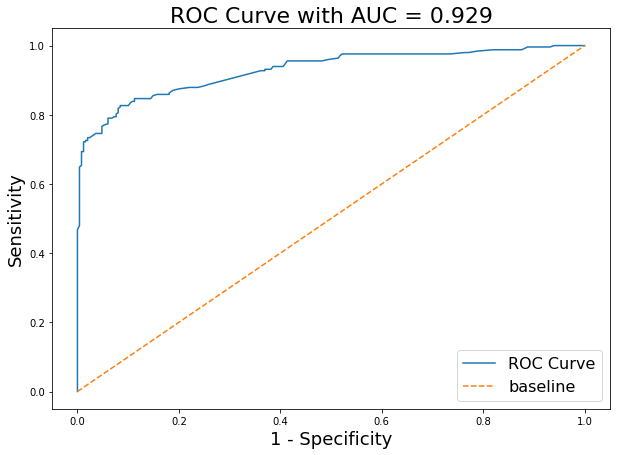

In [55]:
plt.figure(figsize = (10,7))

# Create threshold values. (Dashed red line in image.)
thresholds = np.linspace(0, 1, 200)

# Define function to calculate sensitivity. (True positive rate.)
def TPR(df, true_col, pred_prob_col, threshold):
    true_positive = df[(df[true_col] == 1) & (df[pred_prob_col] >= threshold)].shape[0]
    false_negative = df[(df[true_col] == 1) & (df[pred_prob_col] < threshold)].shape[0]
    return true_positive / (true_positive + false_negative)
    

# Define function to calculate 1 - specificity. (False positive rate.)
def FPR(df, true_col, pred_prob_col, threshold):
    true_negative = df[(df[true_col] == 0) & (df[pred_prob_col] <= threshold)].shape[0]
    false_positive = df[(df[true_col] == 0) & (df[pred_prob_col] > threshold)].shape[0]
    return 1 - (true_negative / (true_negative + false_positive))
    
# Calculate sensitivity & 1-specificity for each threshold between 0 and 1.
tpr_values = [TPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]
fpr_values = [FPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]

# Plot ROC curve.
plt.plot(fpr_values, # False Positive Rate on X-axis
         tpr_values, # True Positive Rate on Y-axis
         label='ROC Curve')

# Plot baseline. (Perfect overlap between the two populations.)
plt.plot(np.linspace(0, 1, 200),
         np.linspace(0, 1, 200),
         label='baseline',
         linestyle='--')

# Label axes.
plt.title(f'ROC Curve with AUC = {round(roc_auc_score(pred_df["true_values"], pred_df["pred_probs"]),3)}', fontsize=22)
plt.ylabel('Sensitivity', fontsize=18)
plt.xlabel('1 - Specificity', fontsize=18)

# Create legend.
plt.legend(fontsize=16);

## Top words <a id='top_words'></a>

**Sports**

In [56]:
pd.DataFrame(best_model.steps[1][1].coef_,
             columns=best_model.steps[0][1].get_feature_names()).T.sort_values(0).head(20)

,0
nba,-3.659506
nfl,-3.369704
football,-3.334281
baseball,-3.280968
sport,-2.688503
basketball,-2.529851
premier,-2.527042
cricket,-2.395574
draft,-2.308713
wa,-2.249426


**Esports**

In [57]:
pd.DataFrame(best_model.steps[1][1].coef_,
             columns=best_model.steps[0][1].get_feature_names()).T.sort_values(0, ascending=False).head(20)

,0
esports,11.133095
valorant,6.467013
tournament,5.815077
csgo,5.716129
gaming,5.463322
esl,4.838987
esport,4.683586
legend,4.361342
dota,4.217826
fortnite,3.224577
